In [1]:
import comod
from comod.models import sir

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
df_flux = pd.read_csv("data/mean_fluxes.csv")
df_flux

,Provincia_origen,Provincia_destino,daily flux (1/day)
0,Albacete,Alicante,247.278689
1,Albacete,Ciudad Real,331.049180
2,Albacete,Cuenca,197.639344
3,Albacete,Murcia,120.016393
4,Albacete,Valencia/Valéncia,223.327869
...,...,...,...
130,Zaragoza,Soria,10.442623
131,Zaragoza,Teruel,7.032787
132,Ávila,Cáceres,77.081967
133,Ávila,Segovia,1.983607


In [4]:
df_population = pd.read_csv("data/population.csv").set_index("NPRO")
df_population

,POB_AREA_GEO
NPRO,
Albacete,303424
Alicante,1723811
Almería,489901
Araba/Álava,294587
Asturias,885568
Badajoz,451181
"Balears, Illes",1118941
Barcelona,5325832
Bizkaia,1062914


In [5]:
# Normalize some sames for clarity
province_normalizer = {
    "Araba/Álava": "Álava",
    "Balears, Illes": "Baleares",
    "Bizkaia": "Vizcaya",
    "Castellón/Castelló": "Castellón",
    "Coruña, A": "La Coruña",
    "Gipuzkoa": "Guipúzcoa",
    "Palmas, Las": "Las Palmas",
    "Rioja, La": "La Rioja",
    "Valencia/Valéncia": "Valencia",
}

In [6]:
provinces = sorted(
    list(
        set(df_flux["Provincia_origen"].unique()).union(
            set(df_flux["Provincia_destino"].unique())
        )
    )
)

In [7]:
df_indexed = df_flux.set_index(["Provincia_origen", "Provincia_destino"])[
    "daily flux (1/day)"
]
m = np.asarray([[df_indexed.get((o, d), 0.0) for d in provinces] for o in provinces])

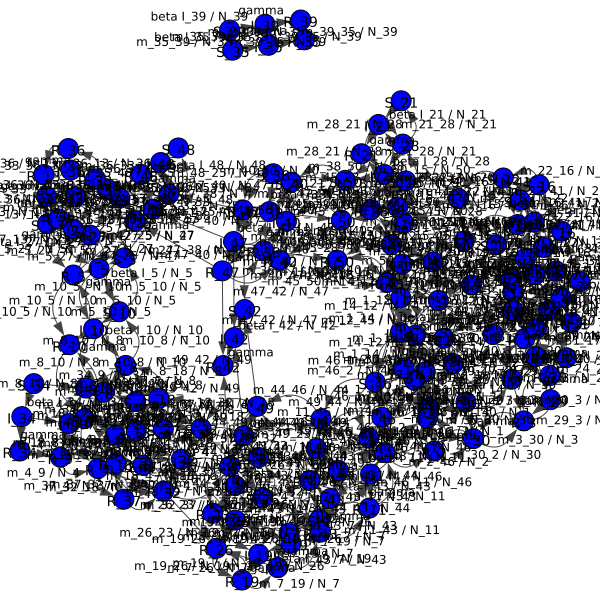

In [8]:
com_model = comod.CommunityModel(sir, m, equal_parameters=True)
com_model.plot_igraph()

In [9]:
def get_parameter(s):
    _, i, j = s.split("_")
    i = int(i)
    j = int(j)
    return m[i - 1][j - 1]

In [10]:
beta = 0.3
gamma = 0.1

In [11]:
parameters = [beta, gamma] + [get_parameter(s) for s in com_model.parameters[2:]]

In [12]:
population = df_population.loc[provinces].values[:, 0]

In [13]:
def get_initial(province, initial_infected=0.001):
    values = np.stack(
        (population, np.zeros_like(population), np.zeros_like(population)), axis=-1
    ).flatten()
    i = provinces.index(province)
    shift = values[i * 3] * initial_infected
    values[i * 3] -= shift
    values[i * 3 + 1] = shift
    return values

In [14]:
t = np.linspace(0, 250, 250)

results = com_model.solve(
    get_initial("Albacete"),
    parameters,
    t,
)

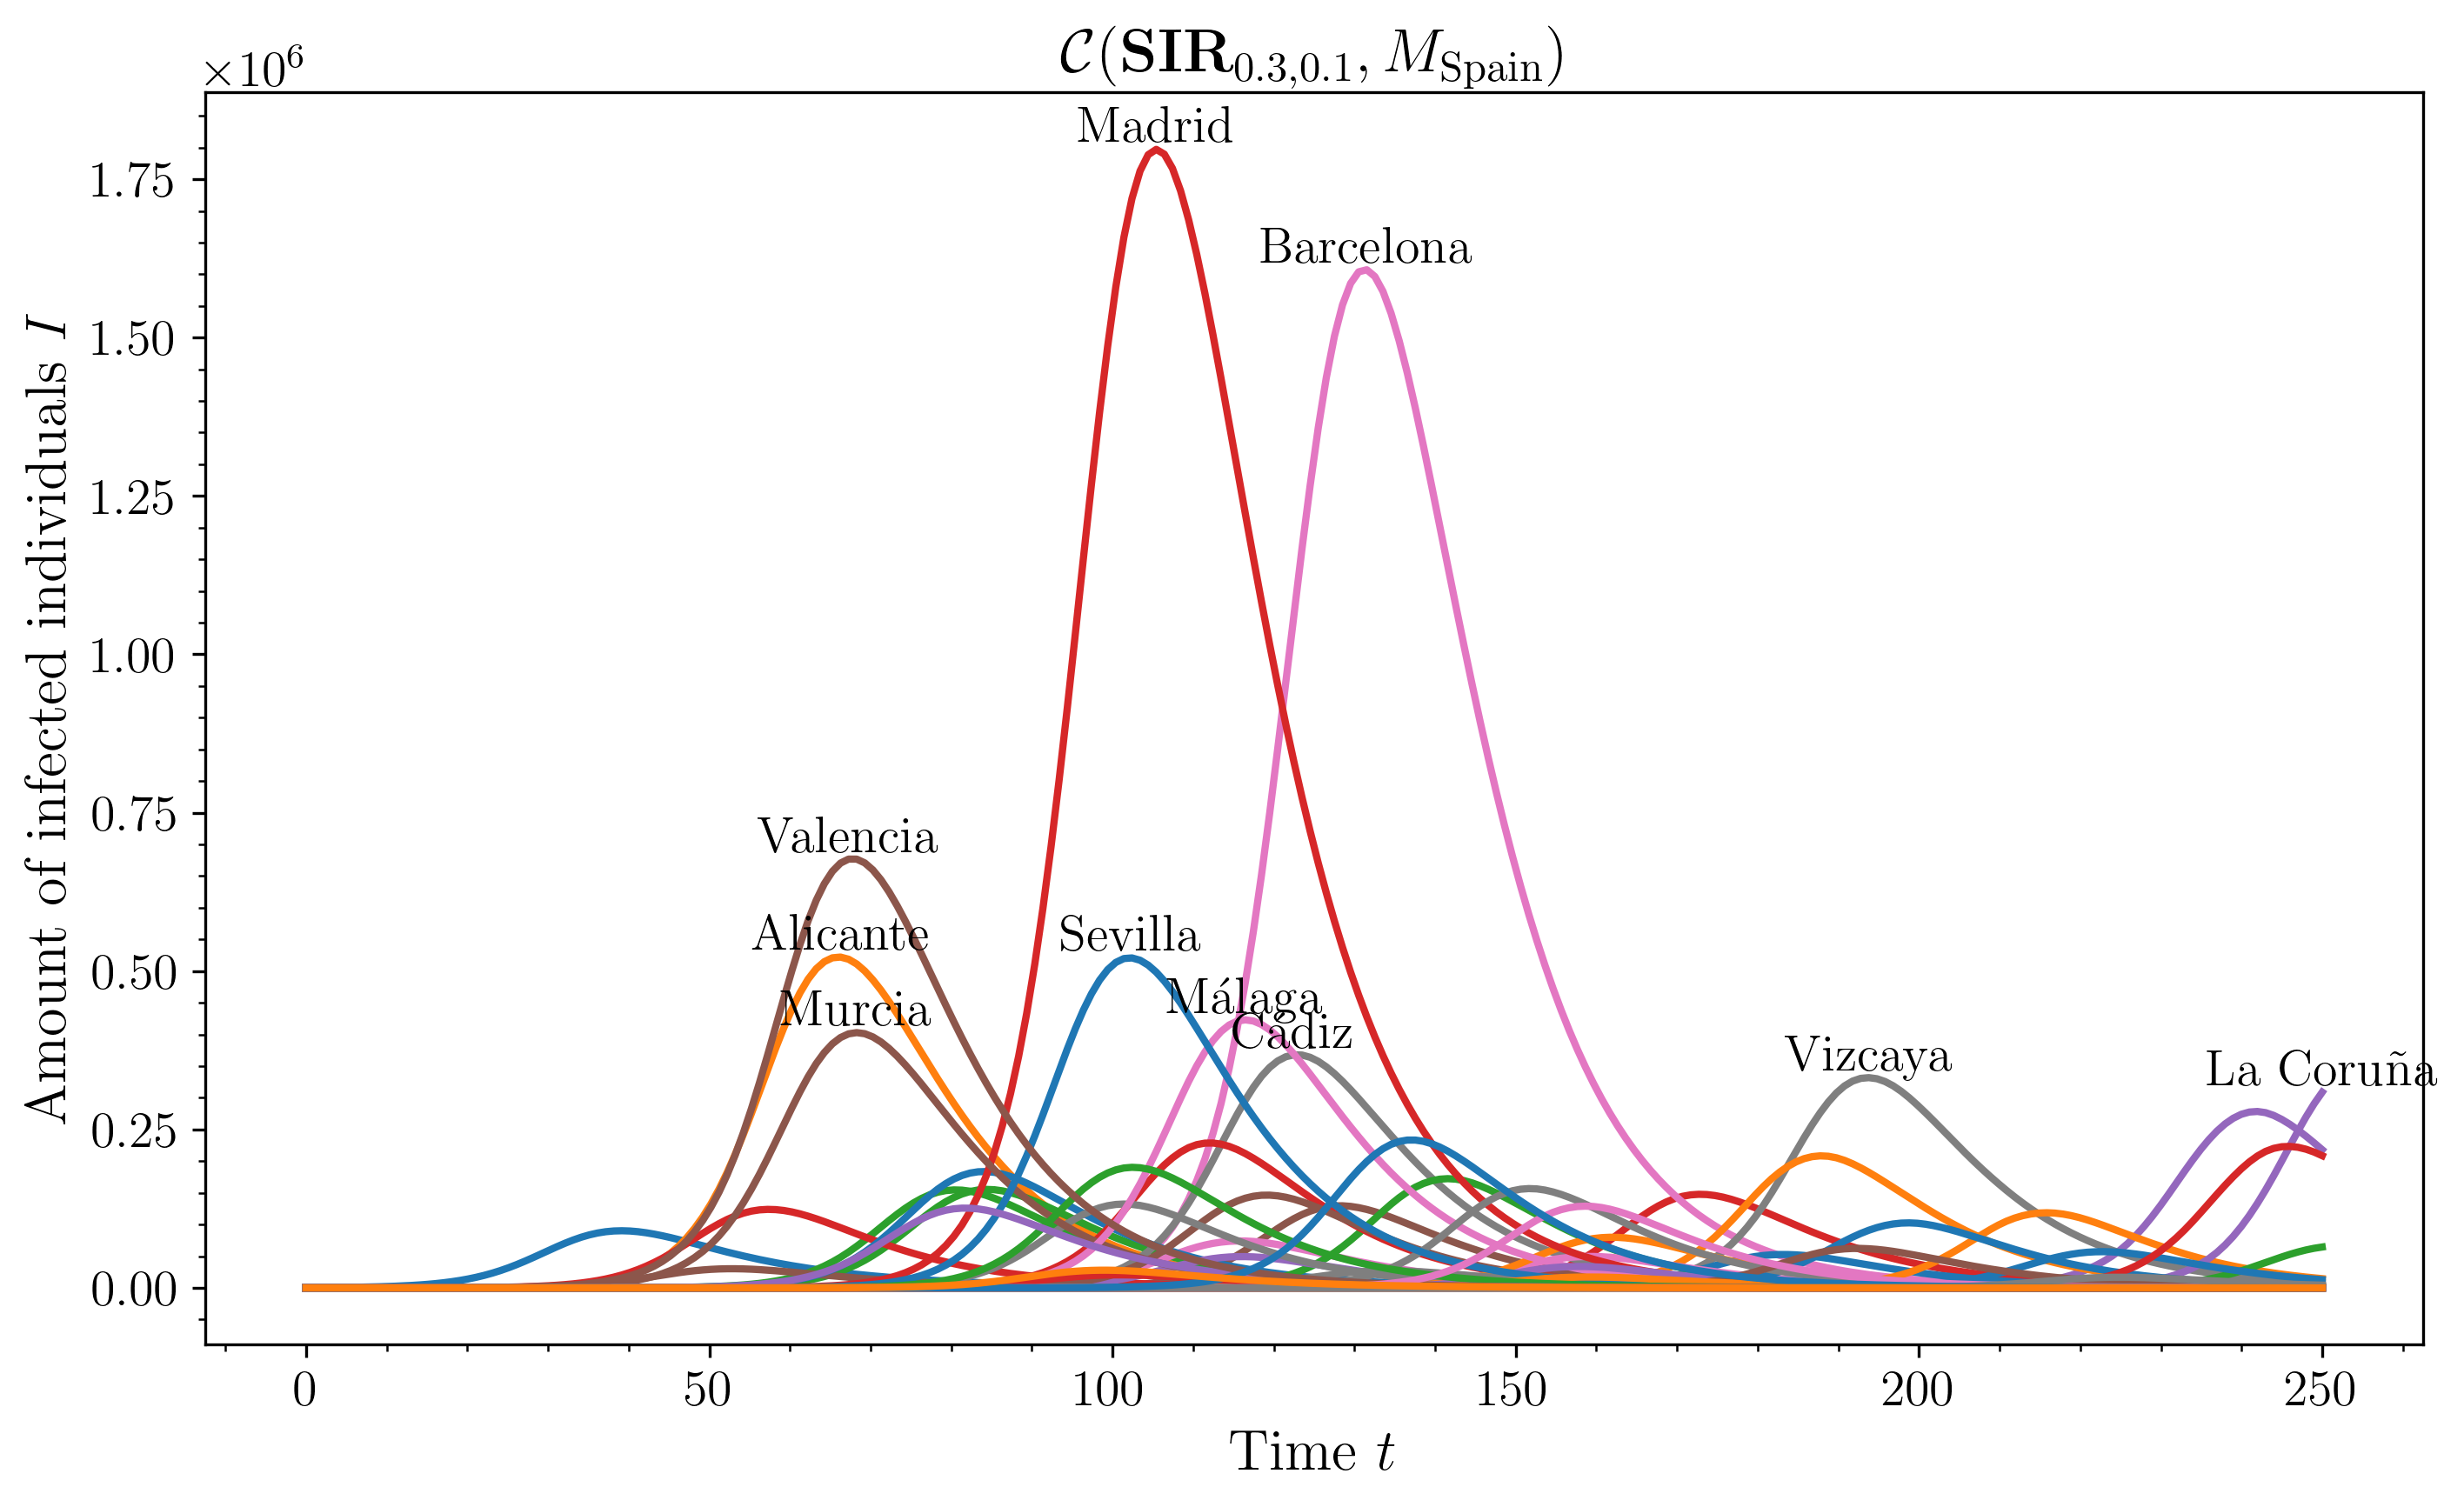

In [15]:
with plt.style.context(["paper"]):
    for i, province in enumerate(provinces):
        plt.plot(t, results[1 + 3 * i])

    # Position of every maximum
    max_locs = np.argmax(results[1::3], axis=1)
    # Maximum values
    max_values = np.max(results[1::3], axis=1)
    # Top maximums
    top_provinces = np.argsort(-max_values)[:10]
    for i in top_provinces:
        # this method is called for each point
        plt.annotate(
            province_normalizer.get(provinces[i], provinces[i]),  # this is the text
            # (t[max_locs[int(i)]],0),
            (
                t[max_locs[i]],
                results[1 + 3 * i, max_locs[i]],
            ),  # this is the point to label
            textcoords="offset points",  # how to position the text
            xytext=(0, 2),  # distance from text to points (x,y)
            ha="center",
        )  # horizontal alignment can be left, right or center

    plt.xlabel("Time $t$")
    plt.ylabel("Amount of infected individuals $I$")
    plt.title(
        fr"$\mathcal{{C}}(\mathrm{{\textbf{{SIR}}}}_{{{beta}, {gamma}}}, M_\mathrm{{Spain}})$"
    )
    plt.tight_layout()
    plt.savefig("out/SIR-Spain-components.pdf")
    plt.show()

In [16]:
S = np.sum(results[::3], axis=0)
I = np.sum(results[1::3], axis=0)
R = np.sum(results[2::3], axis=0)

In [17]:
def effective_R0(SIR):
    SIR = np.asarray(SIR)
    # Central difference (wrt 1:-1)
    S_dot = SIR[0, 2:] - SIR[0, :-2]
    R_dot = SIR[2, 2:] - SIR[2, :-2]
    return -(S_dot * np.sum(SIR[:, 1:-1], axis=0)) / (SIR[0, 1:-1] * R_dot)

In [18]:
fit_pars = sir.best_fit(
    np.asarray([S, I, R]),
    t,
    [0.3, 0.1],
    target="y",
).x

In [19]:
sliding_fit_pars = sir.best_sliding_fit(
    np.asarray([S, I, R]), t, [0.3, 0.1], target="y", window_size=10, step_size=10
)

In [20]:
from scipy.interpolate import interp1d

f_list = [
    interp1d(sliding_fit_pars.index, sliding_fit_pars[c], fill_value="extrapolate")
    for c in sliding_fit_pars.columns
]

In [21]:
S_sliding_fit, I_sliding_fit, R_sliding_fit = sir.solve_time(
    (S[0], I[0], R[0]),  # Initial state
    f_list,  # Coefficient values
    t,  # Time mesh
    method="RK45",  # see scipy.integrate.solve_ivp
)

In [22]:
S_fit, I_fit, R_fit = sir.solve(
    (S[0], I[0], R[0]),  # Initial state
    fit_pars,  # Coefficient values
    t,  # Time mesh
    method="RK45",  # see scipy.integrate.solve_ivp
)

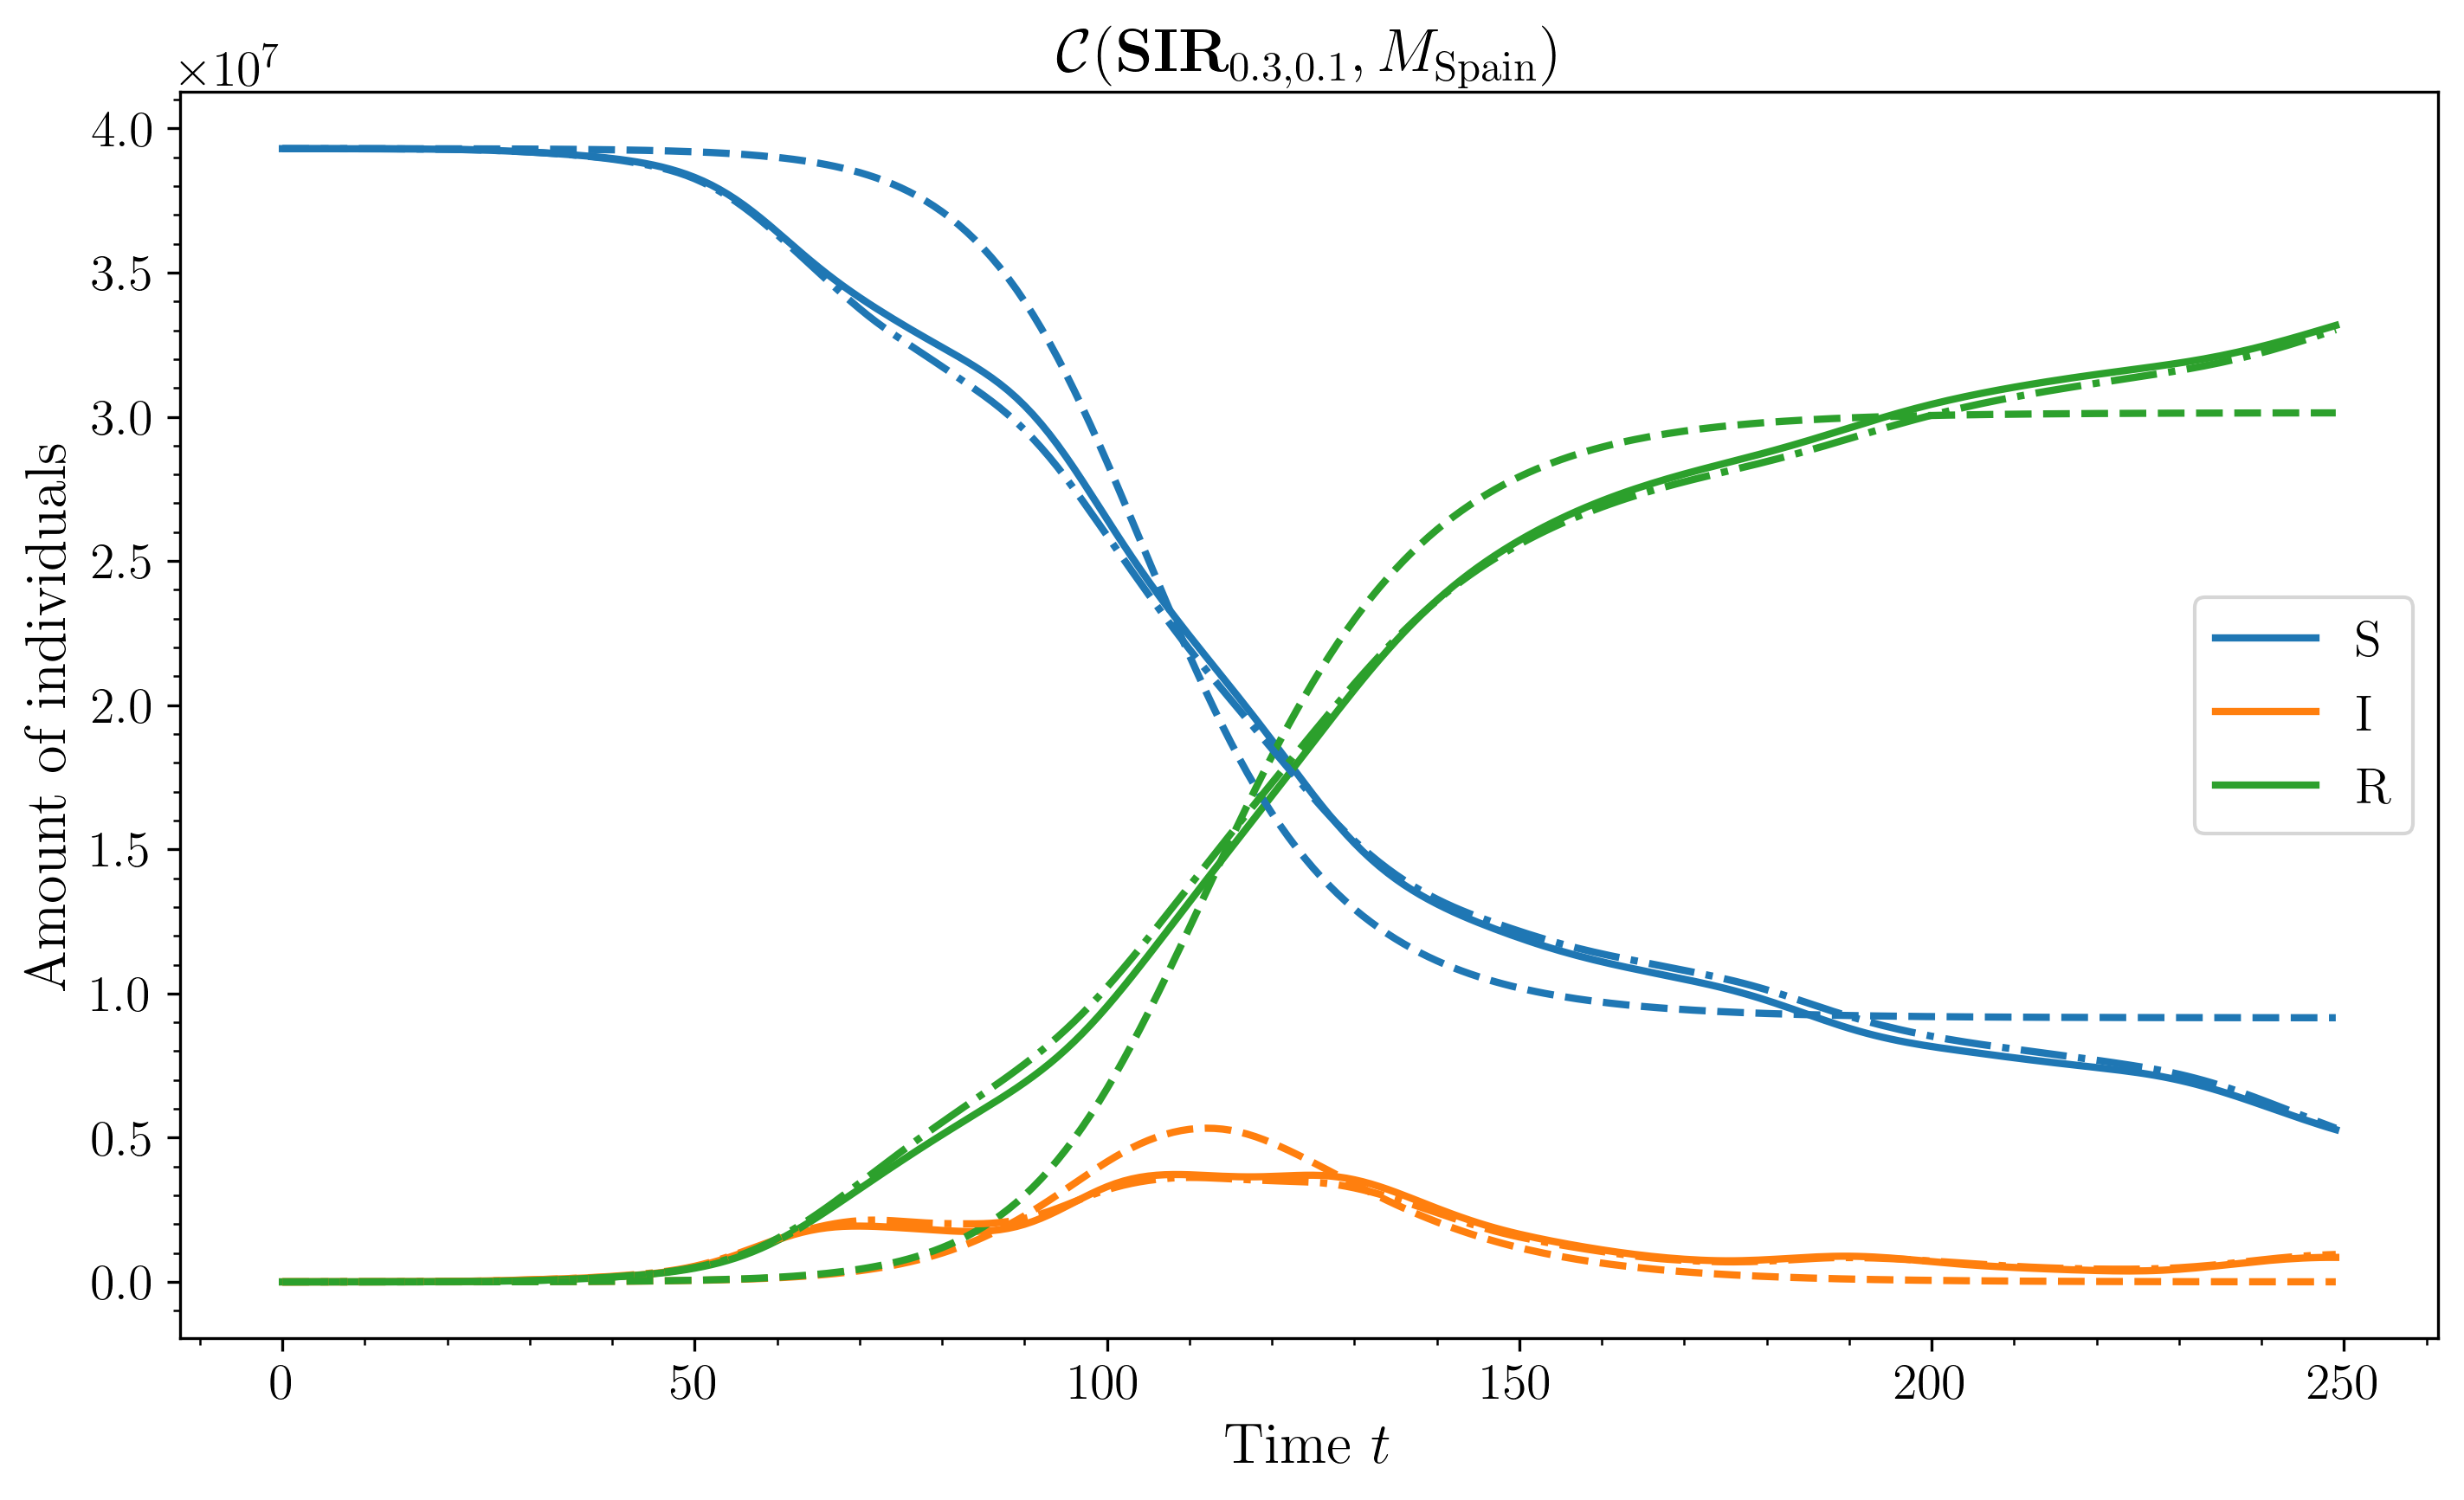

In [23]:
with plt.style.context(["paper"]):
    plt.plot(S)
    plt.plot(I)
    plt.plot(R)
    plt.plot(S_fit, "C0--")
    plt.plot(I_fit, "C1--")
    plt.plot(R_fit, "C2--")
    plt.plot(S_sliding_fit, "C0-.")
    plt.plot(I_sliding_fit, "C1-.")
    plt.plot(R_sliding_fit, "C2-.")

    # errors=(np.sum((S-S_fit)**2), np.sum((I-I_fit)**2), np.sum((R-R_fit)**2))
    # plt.legend([f"{l} ($d_2\\approx{e:.2f}$)" for l,e in zip("SIR", errors)])
    plt.legend(list("SIR"))
    plt.xlabel("Time $t$")
    plt.ylabel("Amount of individuals")
    plt.title(
        fr"$\mathcal{{C}}(\mathrm{{\textbf{{SIR}}}}_{{{beta}, {gamma}}}, M_\mathrm{{Spain}})$"
    )

    plt.tight_layout()
    # plt.savefig(f"SIR-{topology}-global-fit.pdf")
    plt.show()

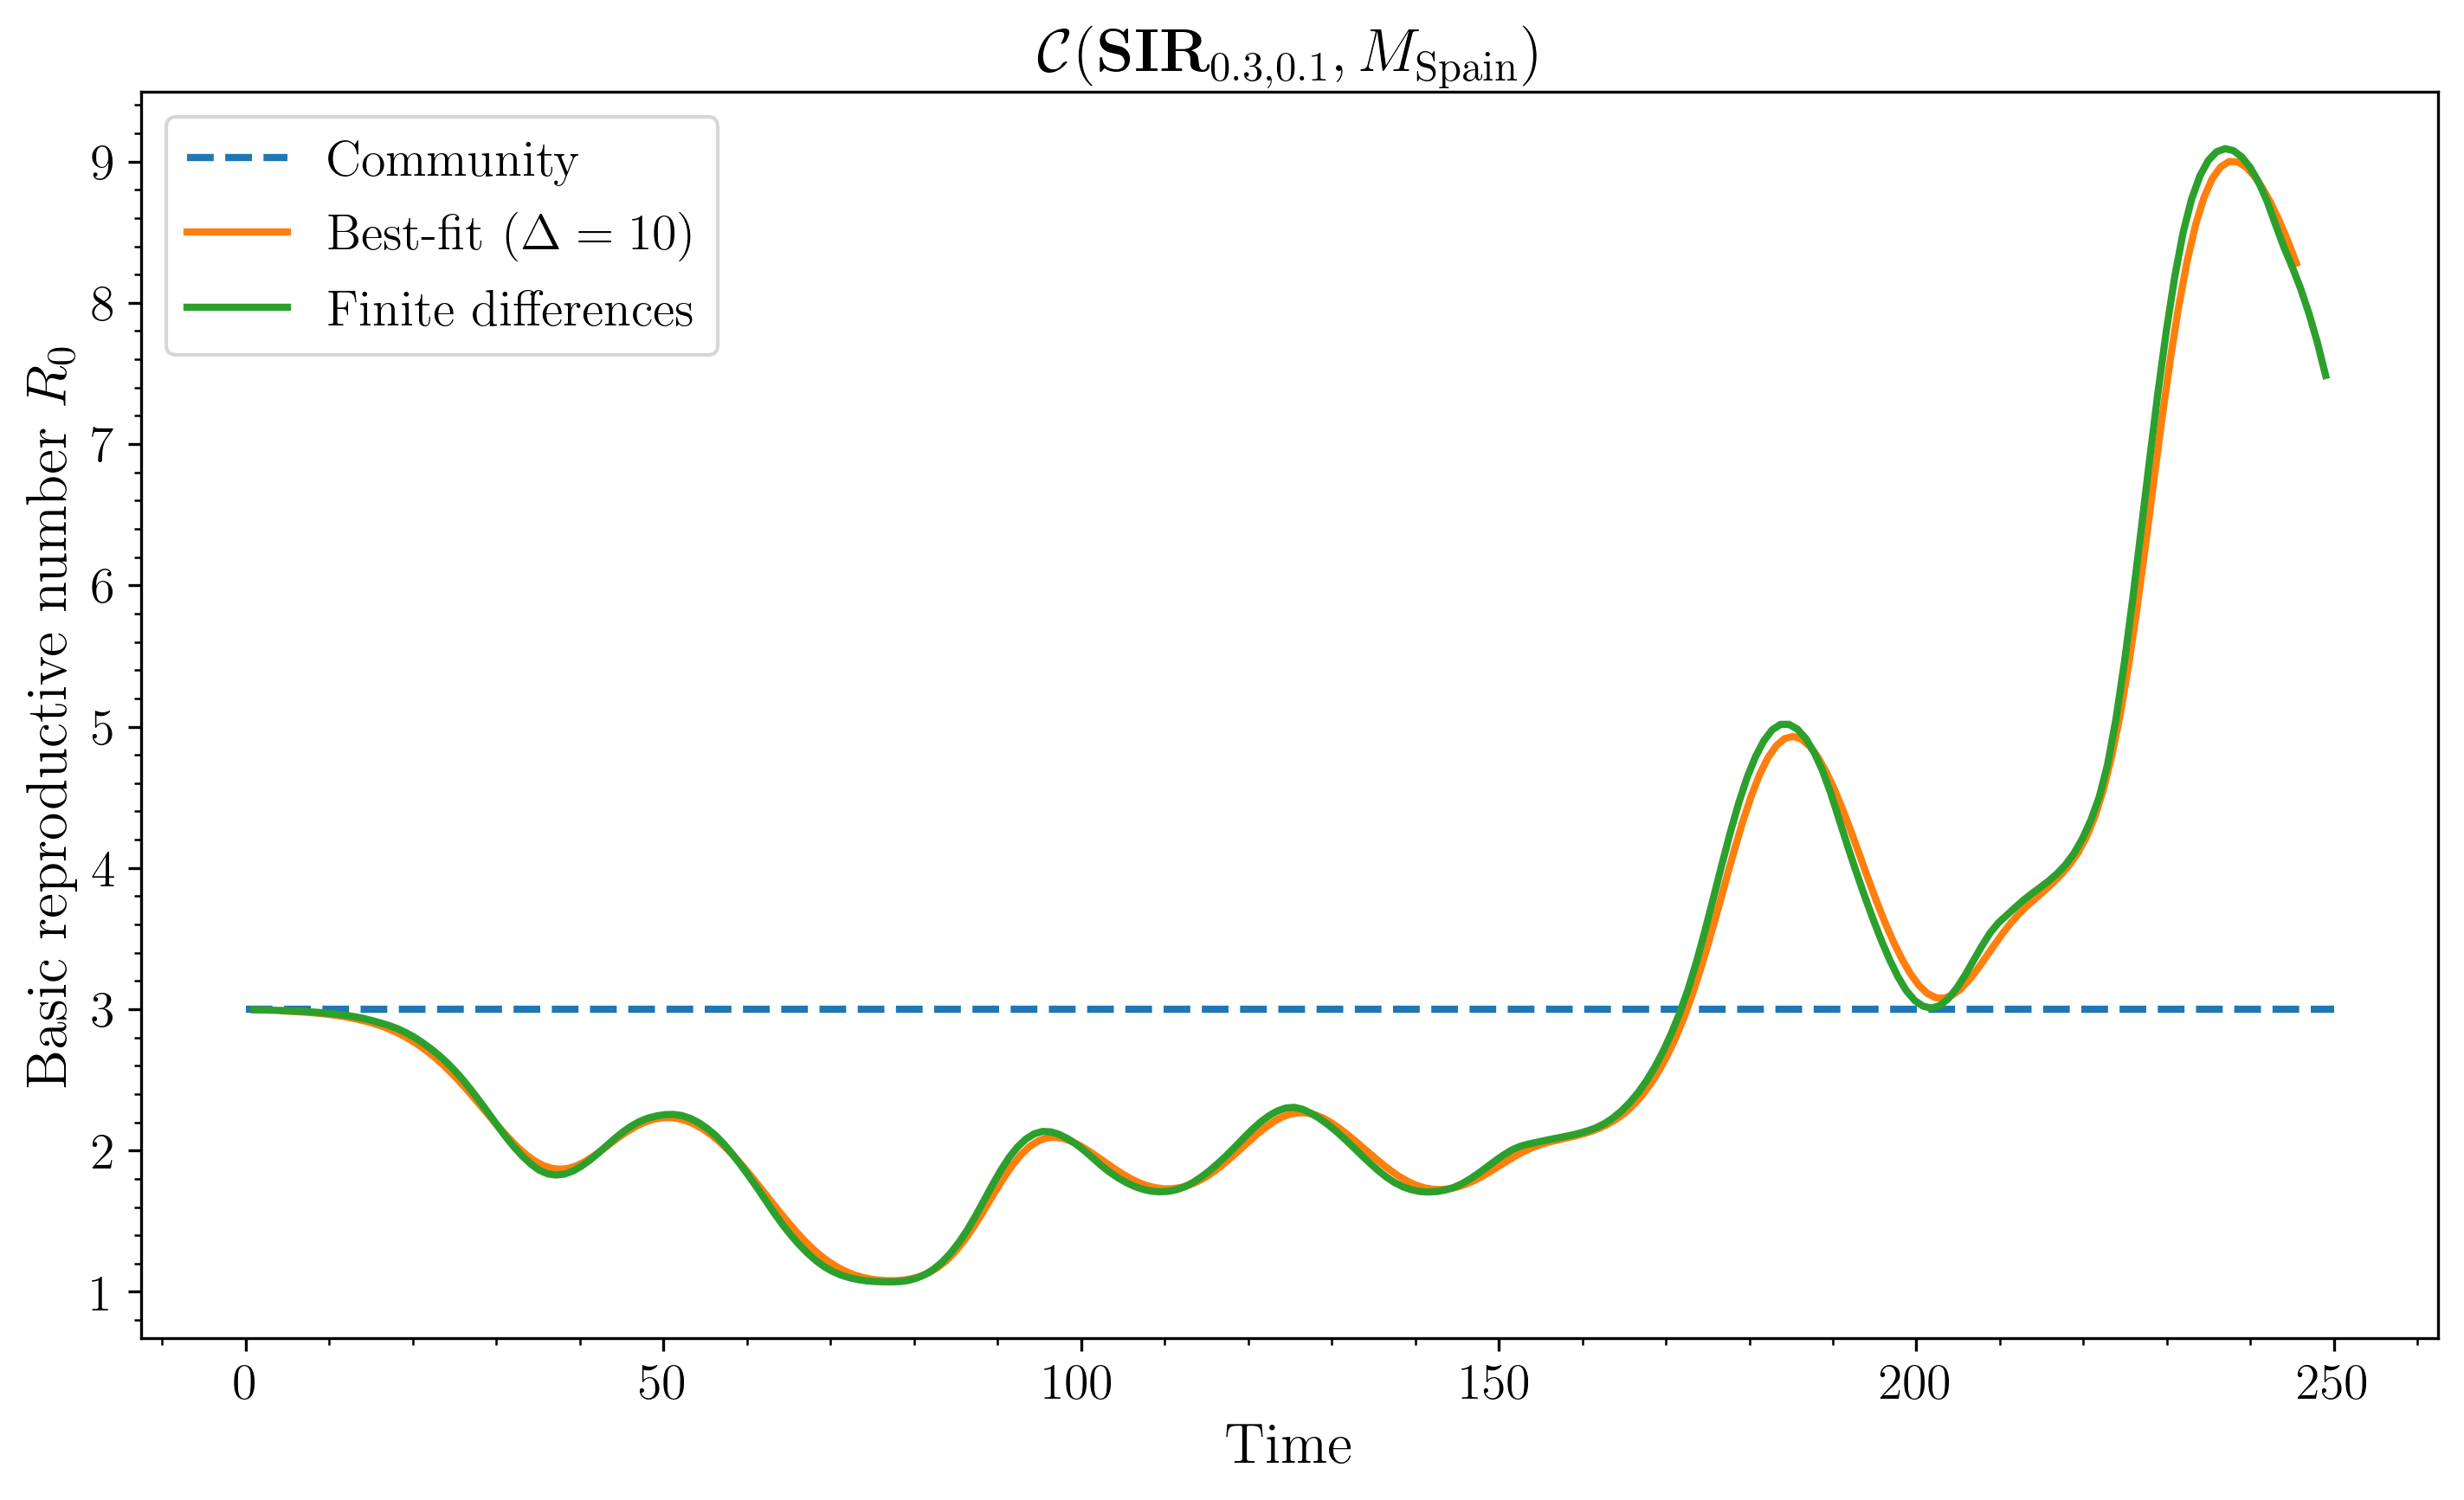

In [24]:
window_size = 10
with plt.style.context(["paper"]):
    sliding_fit = sir.best_sliding_fit(
        (S, I, R), t, (beta, gamma), window_size, 1, target="y"
    )
    plt.plot(t[[0, -1]], [0.3 / 0.1] * 2, "--", label="Community")
    plt.plot(
        sliding_fit.apply(lambda row: row["beta"] / row["gamma"], axis=1),
        label=f"Best-fit ($\\Delta={window_size}$)",
    )
    plt.plot(t[1:-1], effective_R0((S, I, R)), label="Finite differences")
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Basic reproductive number $R_0$")
    plt.title(
        fr"$\mathcal{{C}}(\mathrm{{\textbf{{SIR}}}}_{{{beta}, {gamma}}}, M_\mathrm{{Spain}})$"
    )
    plt.tight_layout()
    plt.savefig(f"out/SIR-Spain-sliding-fit.pdf")
    plt.show()